In [ ]:
import pandas as pd
import math
import numpy as np
import datetime

import matplotlib.pyplot as plt

import time

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import r2_score

import pandas_datareader.data as web
import pprint
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.dates as mdates

%matplotlib inline

# from genetic_selection import GeneticSelectionCV   
# I have phone verification issue. So i can't import this module

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# install pydrive to load data
#!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = "1_71asScU8XI31EIcWF_ikPj0ihvcgfOu"  
file = drive.CreateFile({'id':id}) 
file.GetContentFile('DOW20200323') 

id = "1raZfnsw8fsxxHQ5e5oFIM-zmmXiiWKCX"  
file = drive.CreateFile({'id':id}) 
file.GetContentFile('DOW20200324') 

In [ ]:
import pandas as pd

dow_324 = pd.read_csv('DOW20200324')
dow_323 = pd.read_csv('DOW20200323')
dow_323.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78070 entries, 0 to 78069
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   symbol          78070 non-null  object 
 1   timestamp       78070 non-null  object 
 2   bid_price       74723 non-null  float64
 3   bid_size        74723 non-null  float64
 4   bid_price_lag   74723 non-null  float64
 5   bid_size_lag    74723 non-null  float64
 6   V_of_B          74723 non-null  float64
 7   ask_price       74723 non-null  float64
 8   ask_size        74723 non-null  float64
 9   ask_price_lag   74723 non-null  float64
 10  ask_size_lag    74723 non-null  float64
 11  V_of_A          74723 non-null  float64
 12  VOI             74723 non-null  float64
 13  OIR             74723 non-null  float64
 14  bid_ask_spread  74723 non-null  float64
 15  VWAP_max        77455 non-null  float64
 16  VWAP_mean       77455 non-null  float64
 17  VWAP_min        77455 non-null 

In [ ]:
dow_323 = dow_323.replace([np.inf, -np.inf], np.nan)
dow_324 = dow_324.replace([np.inf, -np.inf], np.nan)

In [ ]:
dow_323 = dow_323.dropna()
dow_324 = dow_324.dropna()

In [ ]:
df_aapl = dow_323[dow_323['symbol'] == 'AAPL'] #Tech
df_wmt = dow_323[dow_323['symbol'] == 'WMT']  #retail
df_jnj = dow_323[dow_323['symbol'] == 'JNJ']  #pharmaceutical

In [ ]:
df_aapl_324 = dow_324[dow_324['symbol'] == 'AAPL'] #Tech
df_wmt_324 = dow_324[dow_324['symbol'] == 'WMT']  #retail
df_jnj_324 = dow_324[dow_324['symbol'] == 'JNJ']  #pharmaceutical

In [ ]:
df_wmt23 = df_wmt.loc[:, ["timestamp", "VOI", "OIR", "bid_ask_spread", "EWM", "OBV", "VWAP_mean"]]
df_wmt24 = df_wmt_324.loc[:, ["timestamp", "VOI", "OIR", "bid_ask_spread", "EWM", "OBV", "VWAP_mean"]]

In [ ]:
df_wmt23.set_index('timestamp', inplace=True) # set column 'date' to index

In [ ]:
df_wmt24.set_index('timestamp', inplace=True) # set column 'date' to index

Preprocessing

In [ ]:
df_wmt23_next10s = df_wmt23["VWAP_mean"].shift(-1)
df_wmt23_next10s = df_wmt23_next10s[0: -1]
df_wmt23 = df_wmt23[0:-1]

In [ ]:
df_wmt24_next10s = df_wmt24["VWAP_mean"].shift(-1)
df_wmt24_next10s = df_wmt24_next10s[0: -1]
df_wmt24 = df_wmt24[0:-1]

In [ ]:
price_movement = df_wmt23["VWAP_mean"] < df_wmt23_next10s

In [ ]:
price_movement24 = df_wmt24["VWAP_mean"] < df_wmt24_next10s 

In [ ]:
#scale normalize all off our data between 0 and 1 with min_max_scaler
min_max_scaler = preprocessing.MinMaxScaler()
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

norm_mydata = min_max_scaler.fit_transform(df_wmt23)
norm_mydata24 = min_max_scaler.transform(df_wmt24)

In [ ]:
min_max_scaler1 = preprocessing.MinMaxScaler()
#scaler1 = StandardScaler()

norm_tomorrows_price = min_max_scaler1.fit_transform(df_wmt23_next10s[:, None])
norm_tomorrows_price24 = min_max_scaler1.transform(df_wmt24_next10s[:, None])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """


### Question: min_max_scale for train/test seperately ?

In [ ]:
norm_train_data = norm_mydata #scale df_wmt23
norm_test_data = norm_mydata24 #scale df_wmt24
norm_train_target = norm_tomorrows_price #scale df_wmt23_next10s
norm_test_target = norm_tomorrows_price24 #scale df_wmt24_next10s


#X_train, X_test, y_train, y_test
norm_train_target_movement = norm_train_target < pd.DataFrame(norm_train_target).shift(-1)
norm_test_target_movement = norm_test_target < pd.DataFrame(norm_test_target).shift(-1)

In [ ]:
train_price_movement = price_movement #df_wmt23["VWAP_mean"] < df_wmt23_next10s
test_price_movement = price_movement24 #df_wmt24["VWAP_mean"] < df_wmt24_next10s 

Linear Regression:

In [ ]:
linear_reg = linear_model.LinearRegression()

In [ ]:
linear_reg.fit(norm_train_data, norm_train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:

linear_reg_results = pd.DataFrame()
tmp = linear_reg.predict(norm_test_data)
linear_reg_results["Price_Predictions"] = tmp.reshape(len(tmp))
linear_reg_results["Price_Movement_Predictions"] = linear_reg_results["Price_Predictions"] < linear_reg_results["Price_Predictions"].shift(-1)

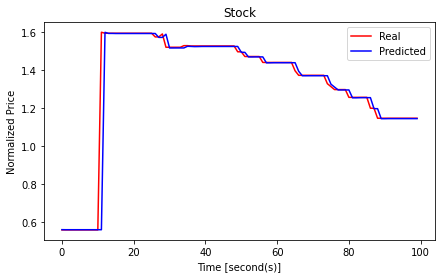

In [ ]:
plt.figure(figsize = (7, 4))
plt.plot(norm_test_target[0:100], "red", label= 'Real')   ## Test Target
plt.plot(linear_reg_results["Price_Predictions"][0:100], "blue", label= 'Predicted')  ## Predicted

plt.title('Stock')
plt.xlabel('Time [second(s)]')
plt.ylabel('Normalized Price')
plt.legend(loc= 'best')
plt.show()

In [ ]:
print("R2 Metric: ", r2_score(norm_test_target, linear_reg_results["Price_Predictions"]))
print("Price Movement Accuracy: ", accuracy_score(linear_reg_results["Price_Movement_Predictions"], norm_test_target_movement))

R2 Metric:  0.9979660499587985
Price Movement Accuracy:  0.7302631578947368


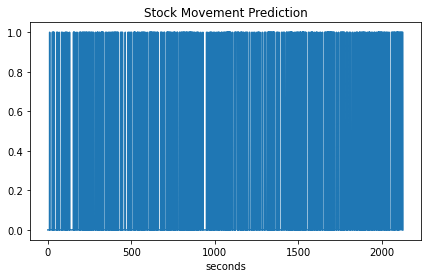

In [ ]:
plt.figure(figsize = (7, 4))
plt.title('Stock Movement Prediction')
plt.plot(linear_reg_results["Price_Movement_Predictions"])
plt.xlabel("seconds")
plt.show()

Support Vector Machines - Regression

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
sv_regression = svm.SVR() 


param = {"C": np.arange(1, 10), 
         "kernel": ["sigmoid", "rbf", "linear"] ,
         "tol": [1e-3, 0.01, 0.1, 1],
         "degree": [1, 2, 3, 4, 5] }

sv_cv = RandomizedSearchCV(sv_regression, param, cv = 2)
sv_cv.fit(norm_train_data, norm_train_target)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'degree': [1, 2, 3, 4, 5],
                                        'kernel': ['sigmoid', 'rbf', 'linear'],
                                        'tol': [0.001, 0.01, 0.1, 1]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
svr_results = pd.DataFrame()
tmp = sv_cv.predict(norm_test_data)
svr_results["Price_Predictions"] = tmp.reshape(len(tmp))
svr_results["Price_Movement_Predictions"] = svr_results["Price_Predictions"] < svr_results["Price_Predictions"].shift(-1)

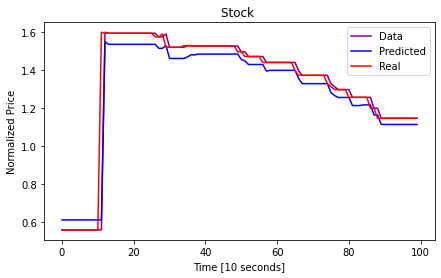

In [ ]:
close_column_index = 5


plt.figure(figsize= (7,4))

#norm_test_data = norm_mydata24 #scale df_wmt24 (100 rows)
plt.plot(pd.DataFrame(norm_test_data)[close_column_index][0:100], "purple", label = "Data" )

#sv_cv.predict(norm_test_data) [100 rows]
plt.plot(svr_results["Price_Predictions"][0:100], "blue", label = "Predicted")

#norm_test_target = norm_tomorrows_price24 #scale df_wmt24_next10s (100 rows)
plt.plot(norm_test_target[0:100], "red", label = "Real")

plt.title('Stock ')
plt.xlabel('Time [10 seconds]')
plt.ylabel('Normalized Price')
plt.legend(loc= 'best')
plt.show()

plt.show()

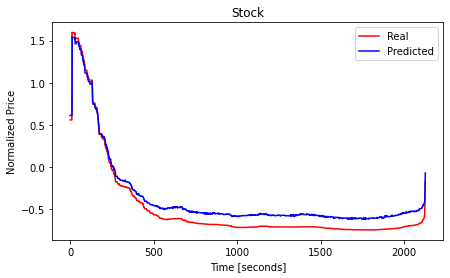

In [ ]:
plt.figure(figsize= (7, 4))
plt.plot(norm_test_target, "red", label = "Real")
plt.plot(svr_results["Price_Predictions"], "blue", label= "Predicted")

plt.title('Stock')
plt.xlabel('Time [seconds]')
plt.ylabel('Normalized Price')
plt.legend(loc= 'best')
plt.show()

In [ ]:
print("R2 Metric: ", r2_score(norm_test_target, svr_results["Price_Predictions"]))
print("Price Movement Accuracy: ", accuracy_score(svr_results["Price_Movement_Predictions"], norm_test_target_movement))

R2 Metric:  0.9427853860814833
Price Movement Accuracy:  0.7593984962406015


## Deep Learning Models - regressor
All show same result. Don't know why.

LSTM

In [ ]:
def createSequentialModel(input_size, activation_function):
    model = Sequential()

    model.add(LSTM(
        input_dim= input_size,
        units=50,
        return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        100,
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        units=1, activation = activation_function))

    model.compile(loss='mse', optimizer='rmsprop')    # can try metrics='accuracy'
    
    return model

In [ ]:
def executeSequentialModel(model, data, target, test_split, epoch):
    min_max_scaler = preprocessing.MinMaxScaler()
    
    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = test_split, random_state = 4, shuffle = False)

    fitted_train_data = min_max_scaler.fit_transform(train_data)
    fitted_test_data = min_max_scaler.fit_transform(test_data)


    train_target = list(train_target)
    test_target = list(test_target)
    
    lstm_train_data = np.reshape(fitted_train_data, (fitted_train_data.shape[0], 1, fitted_train_data.shape[1]))
    lstm_test_data = np.reshape(fitted_test_data, (fitted_test_data.shape[0],1, fitted_test_data.shape[1]))
    
    print(lstm_train_data.shape)
    print(lstm_test_data.shape)

    lstm_train_target = np.reshape(train_target, (len(train_target), 1))
    lstm_test_target = np.reshape(test_target, (len(test_target), 1))
    
    
    model.fit(
    lstm_train_data,
    lstm_train_target,
    batch_size=256,
    epochs= epoch,
    validation_split=0.2, shuffle = False)
    
    predictions = min_max_scaler.fit_transform(model.predict(lstm_test_data))
    
    predictions = predictions.reshape(len(predictions))
    
#     plt.plot(predictions)
#     plt.show()
    
    return accuracy_score(predictions > 0.5 , test_target, normalize = True), predictions

In [ ]:
lstm_model = createSequentialModel(norm_train_data.shape[1], "relu")

In [ ]:
lstm_train_data= norm_train_data.reshape(norm_train_data.shape[0],1, norm_train_data.shape[1])   # 23
lstm_test_data= norm_test_data.reshape(norm_test_data.shape[0],1, norm_test_data.shape[1])        # 24

In [ ]:
history= lstm_model.fit(
    lstm_train_data,
    norm_train_target,
    batch_size=100,
    epochs= 30,
    validation_split=0.2, shuffle = False)

Epoch 1/30
19/19 [==============================] - 1s 39ms/step - loss: 0.1573 - val_loss: 0.0049
Epoch 2/30
19/19 [==============================] - 0s 7ms/step - loss: 0.0572 - val_loss: 0.0220
Epoch 3/30
19/19 [==============================] - 0s 6ms/step - loss: 0.0397 - val_loss: 0.0231
Epoch 4/30
19/19 [==============================] - 0s 7ms/step - loss: 0.0355 - val_loss: 0.0207
Epoch 5/30
19/19 [==============================] - 0s 7ms/step - loss: 0.0318 - val_loss: 0.0181
Epoch 6/30
19/19 [==============================] - 0s 7ms/step - loss: 0.0275 - val_loss: 0.0159
Epoch 7/30
19/19 [==============================] - 0s 7ms/step - loss: 0.0245 - val_loss: 0.0132
Epoch 8/30
19/19 [==============================] - 0s 5ms/step - loss: 0.0212 - val_loss: 0.0111
Epoch 9/30
19/19 [==============================] - 0s 6ms/step - loss: 0.0186 - val_loss: 0.0087
Epoch 10/30
19/19 [==============================] - 0s 6ms/step - loss: 0.0160 - val_loss: 0.0068
Epoch 11/30
19/19 

In [ ]:
lstm_reg_results = pd.DataFrame()
tmp = lstm_model.predict(lstm_test_data)      # 24_x
lstm_reg_results["Price_Predictions"] = tmp.reshape(len(tmp))
lstm_reg_results["Price_Movement_Predictions"] = lstm_reg_results["Price_Predictions"] < lstm_reg_results["Price_Predictions"].shift(-1)

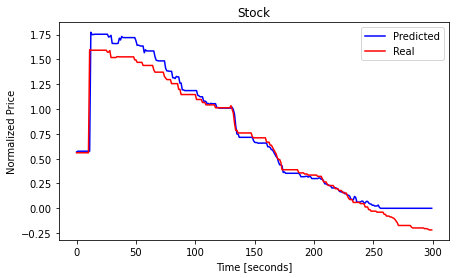

In [ ]:
plt.figure(figsize = (7,4))
plt.plot(lstm_reg_results["Price_Predictions"][0:300], "blue", label = "Predicted")
plt.plot(norm_test_target[0:300],"red", label = "Real")

plt.title('Stock')
plt.xlabel('Time [seconds]')
plt.ylabel('Normalized Price')
plt.legend(loc= 'best')

plt.show()

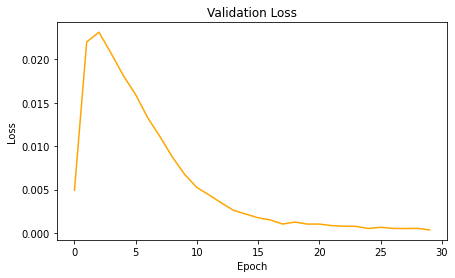

In [ ]:
plt.figure(figsize= (7,4))
plt.plot(history.history["val_loss"], "orange")
plt.title("Validation Loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

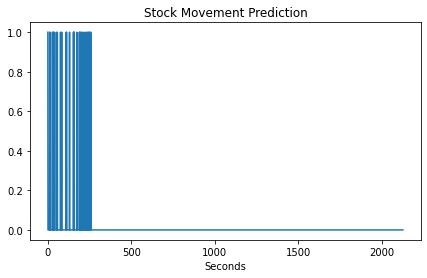

In [ ]:
plt.figure(figsize= (7,4))
plt.plot(lstm_reg_results["Price_Movement_Predictions"])
plt.title("Stock Movement Prediction")
plt.xlabel("Seconds")   # tick
plt.show()

In [ ]:
print("R2 Metric: ", r2_score(norm_test_target, lstm_reg_results["Price_Predictions"]))
print("Price Movement Accuracy: ", accuracy_score(lstm_reg_results["Price_Movement_Predictions"], norm_test_target_movement))

R2 Metric:  -0.3858807144437808
Price Movement Accuracy:  0.9083646616541353


R2 value is negative, not sure if that's a problem?

CNN

In [ ]:
from keras.layers.core import Dense, Dropout, Activation
cnn_model = Sequential([
    Dense(30),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(1),
    Activation("relu")
])
cnn_model.compile(loss='mse', optimizer='rmsprop')
# Fit 323 data
history = cnn_model.fit(norm_train_data, norm_train_target, 
                    epochs=30, batch_size=100)

Epoch 1/30
24/24 [==============================] - 0s 3ms/step - loss: 0.2026
Epoch 2/30
24/24 [==============================] - 0s 2ms/step - loss: 0.2026
Epoch 3/30
24/24 [==============================] - 0s 3ms/step - loss: 0.2026
Epoch 4/30
24/24 [==============================] - 0s 2ms/step - loss: 0.2026
Epoch 5/30
24/24 [==============================] - 0s 2ms/step - loss: 0.2026
Epoch 6/30
24/24 [==============================] - 0s 3ms/step - loss: 0.2026
Epoch 7/30
24/24 [==============================] - 0s 2ms/step - loss: 0.2026
Epoch 8/30
24/24 [==============================] - 0s 3ms/step - loss: 0.2026
Epoch 9/30
24/24 [==============================] - 0s 3ms/step - loss: 0.2026
Epoch 10/30
24/24 [==============================] - 0s 3ms/step - loss: 0.2026
Epoch 11/30
24/24 [==============================] - 0s 3ms/step - loss: 0.2026
Epoch 12/30
24/24 [==============================] - 0s 3ms/step - loss: 0.2026
Epoch 13/30
24/24 [==============================

In [ ]:
cnn_reg_results = pd.DataFrame()
cnn_tmp = cnn_model.predict(norm_test_data)      # 24_x
cnn_reg_results["Price_Predictions"] = tmp.reshape(len(cnn_tmp))
cnn_reg_results["Price_Movement_Predictions"] = cnn_reg_results["Price_Predictions"] < cnn_reg_results["Price_Predictions"].shift(-1)

In [ ]:
print("R2 Metric: ", r2_score(norm_test_target, cnn_reg_results["Price_Predictions"]))
print("Price Movement Accuracy: ", accuracy_score(cnn_reg_results["Price_Movement_Predictions"], norm_test_target_movement))

R2 Metric:  -0.3858807144437808
Price Movement Accuracy:  0.9083646616541353


--Hyper-param tuning area--

In [ ]:
# First we will create a wrapper function
def build_model(n_hidden = 1, n_neurons = 30, activation = 'relu', learning_rate = 0.001):
    model = Sequential() # Instantiate the model
    #act_options = {"activation":  activation }
    model.add(Dense(n_neurons, activation = 'relu', input_dim =norm_train_data.shape[1]))  # input layer
    # hidden layers
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = 'relu')) 
    model.add(Dense(1, activation = 'relu'))   # output layer
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse',  optimizer = optimizer)
    return model

In [ ]:
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model) 

In [ ]:
from sklearn.model_selection import GridSearchCV
param = {'n_hidden': [3,5,8,10],
        'n_neurons':[5,10,30,50],
        'learning_rate':[0.1, 0.01, 0.001]}
         #'activation': ['softmax','relu','selu']#

grd_cv = GridSearchCV(keras_reg, param, cv = 2, n_jobs = -1)

In [ ]:
# take 5 minutes to run
grd_cv.fit(norm_train_data, norm_train_target, epochs = 30,
          callbacks = tf.keras.callbacks.EarlyStopping(patience=3))

Epoch 1/30
73/73 [==============================] - 0s 2ms/step - loss: 0.0547
Epoch 2/30
73/73 [==============================] - 0s 2ms/step - loss: 0.0331
Epoch 3/30
73/73 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 4/30
73/73 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 5/30
73/73 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6/30
73/73 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 7/30
73/73 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 8/30
73/73 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 9/30
73/73 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 10/30
73/73 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 11/30
73/73 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 12/30
73/73 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 13/30
73/73 [==============================

GridSearchCV(cv=2, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f6f14dc34a8>,
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_hidden': [3, 5, 8, 10],
                         'n_neurons': [5, 10, 30, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
grd_cv.best_params_

{'learning_rate': 0.1, 'n_hidden': 5, 'n_neurons': 5}

In [ ]:
tun_cnn_reg_results = pd.DataFrame()
tun_cnn_tmp = grd_cv.predict(norm_test_data)      # 24_x
tun_cnn_reg_results["Price_Predictions"] = tmp.reshape(len(tun_cnn_tmp))
tun_cnn_reg_results["Price_Movement_Predictions"] = tun_cnn_reg_results["Price_Predictions"] < tun_cnn_reg_results["Price_Predictions"].shift(-1)

In [ ]:
print("R2 Metric: ", r2_score(norm_test_target, tun_cnn_reg_results["Price_Predictions"]))
print("Price Movement Accuracy: ", accuracy_score(tun_cnn_reg_results["Price_Movement_Predictions"], norm_test_target_movement))

R2 Metric:  -0.3858807144437808
Price Movement Accuracy:  0.9083646616541353


No improvement after tuning if I use the regression activation, but improvement exists if choose the classification activation.